In [1]:
%load_ext autoreload

In [2]:
# !pip install wandb
# import wandb

%autoreload 2
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Our fancy new modules
import subgrid_parameterization.arch.ann as ann
import subgrid_parameterization.preprocess.SAM_helpers as sam
from subgrid_parameterization.preprocess.torch_helpers import split_dataset
from subgrid_parameterization.util.earlystopper import EarlyStopper
import subgrid_parameterization.util.plot_helpers as plot_helpers

from subgrid_parameterization.preprocess.C14 import get_C14
from subgrid_parameterization.preprocess.mixing_length import get_mixing_length

import xarray as xr
import numpy as np
from sklearn.metrics import r2_score

In [3]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

path = "sam-bomex/"
file = "BOMEX_64x64x75_100m_40m_1s"
save = "C14_trainDYCOMS_testBOMEX"
# file = 'BOMEX_3d'

# path = 'sam-rf01/'
# file = 'DYCOMS_RF01_96x96x320'
# save = 'C14profiles_DYCOMS'
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = 'sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

ds = xr.open_dataset(path0 + path + file + ".nc")
ds

<xarray.Dataset> Size: 47MB
Dimensions:      (x: 1, y: 1, z: 75, time: 360)
Coordinates:
  * x            (x) float32 4B -56.5
  * y            (y) float32 4B 15.0
  * z            (z) float32 300B 20.0 60.0 100.0 ... 2.9e+03 2.94e+03 2.98e+03
  * time         (time) datetime64[ns] 3kB 1969-06-22T00:01:00 ... 1969-06-22...
Data variables: (12/446)
    p            (z) float32 300B ...
    PREC         (time) float32 1kB ...
    CWP          (time) float32 1kB ...
    IWP          (time) float32 1kB ...
    RWP          (time) float32 1kB ...
    SWP          (time) float32 1kB ...
    ...           ...
    THLPRRP_IP   (time, z, y, x) float32 108kB ...
    RTPNRP_IP    (time, z, y, x) float32 108kB ...
    THLPNRP_IP   (time, z, y, x) float32 108kB ...
    RRPNRP_IP    (time, z, y, x) float32 108kB ...
    RRP3_IP      (time, z, y, x) float32 108kB ...
    NRP3_IP      (time, z, y, x) float32 108kB ...
Attributes:
    SAM version:  
    caseid:       64x64x75_100m_40m_1s
    Conventions:  COARDS

In [4]:
path = "sam-bomex/"
file = "BOMEX_64x64x75_100m_40m_1s"
ds = xr.open_dataset(path0 + path + file + ".nc")
save = "C14_2LES"

nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)
L, Lup, Ldown = get_mixing_length(ds)
Hscale = 1000  # 1km
C14 = get_C14(ds)
up2 = sam.stagger_var("U2", ds)
vp2 = sam.stagger_var("V2", ds)
wp2 = sam.stagger_var("W2", ds)
e = 0.5 * (up2 + vp2 + wp2)
disp = sam.get_disp(ds)
C14min = 0.2
C14max = 2
minMask = disp < -3/2*C14min/L*e**1.5
maxMask = e >  (-1.5*disp*L/C14max)**(2/3)
input = list()
output = list()
for it in range(ngrdcol):
    for k in range(nzt):
        if minMask[it, k] and maxMask[it, k]:  
            input.append(
                [
                    up2[it, k] / e[it, k],
                    up2[it, k] / e[it, k],
                    up2[it, k] / e[it, k],
                    Lup[it, k] / Hscale,
                    Ldown[it, k] / Hscale,
                ]
            )
            output.append([C14[it, k]])
print(str(len(input)) + " samples")
bomex_dataset = Data.TensorDataset(torch.tensor(input), torch.tensor(output))

6522 samples


/glade/derecho/scratch/adac/tmp/ipykernel_7118/2602393127.py:18: RuntimeWarning: invalid value encountered in power
  maxMask = e >  (-1.5*disp*L/C14max)**(2/3)


In [5]:
path = "sam-rf01/"
file = "DYCOMS_RF01_96x96x320"
ds = xr.open_dataset(path0 + path + file + ".nc")

nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)
L, Lup, Ldown = get_mixing_length(ds)
Hscale = 1000  # 1km
C14 = get_C14(ds)
up2 = sam.stagger_var("U2", ds)
vp2 = sam.stagger_var("V2", ds)
wp2 = sam.stagger_var("W2", ds)
e = 0.5 * (up2 + vp2 + wp2)
input = list()
output = list()
disp = sam.get_disp(ds)
C14min = 0.2
C14max = 2
minMask = disp < -3/2*C14min/L*e**1.5
maxMask = e >  (-1.5*disp*L/C14max)**(2/3)
input = list()
output = list()
for it in range(ngrdcol):
    for k in range(nzt):
        if minMask[it, k] and maxMask[it, k]:  
            input.append(
                [
                    up2[it, k] / e[it, k],
                    up2[it, k] / e[it, k],
                    up2[it, k] / e[it, k],
                    Lup[it, k] / Hscale,
                    Ldown[it, k] / Hscale,
                ]
            )
            output.append([C14[it, k]])
print(str(len(input)) + " samples")
dycoms_dataset = Data.TensorDataset(torch.tensor(input), torch.tensor(output))

18031 samples


/glade/derecho/scratch/adac/tmp/ipykernel_7118/3842272553.py:19: RuntimeWarning: invalid value encountered in power
  maxMask = e >  (-1.5*disp*L/C14max)**(2/3)


In [6]:
# train_dataset,test_dataset = split_dataset(bomex_dataset,0.2) #random_split(bomex_dataset,[0.8,0.2]) returns a Subset so doesn't work later
# train_dataset = bomex_dataset
# test_dataset = dycoms_dataset
train_dataset = dycoms_dataset
test_dataset = bomex_dataset

In [7]:
_, C14train = train_dataset.tensors
# np.array([numerator/(np.std(np.array(output)[:,i])) for i in range(np.array(output).shape[1])])
lossweights = np.ones(C14train.detach().numpy().shape[1])

In [8]:
config = {
    "batch_size": 360,
    "lr": 0.0001,  ## learning rate
    "wd": 0.01,  ## weight decay
    "epochs": 2000,  ## Setting this to a high number because early stopping
    # "subsample":10,   ## Take a subsample of 1000 data points
    "patience": 50,  ## Patience for early stopping
}

beta1 = 0.5
beta2 = 0.999

In [9]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda")
else:
    print("CUDA Not Available")
    device = torch.device("cpu")

CUDA Not Available


In [10]:
## Construct training and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

## Record number of training/validation images
# config["training_fields"]=len(pyqg_dataset.test_idx)
# config["validation_fields"]=len(pyqg_dataset.valid_idx)

In [11]:
nvars = 5  # ups,vp2,wp2,Lup,Ldown
iso = True
if iso:
    nvarsout = 1
else:
    nvarsout = 2

N = [nvars, 16, 8, nvarsout]

try:
    del model
    model = ann.ANN(N).double()  ## NN architecture: could be FCNN, resnet, ANN.. etc
except:
    model = ann.ANN(N).double()  ## NN architecture: could be FCNN, resnet, ANN.. etc

model.to(device)
config["learnable parameters"] = sum(p.numel() for p in model.parameters())

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["lr"],
)  # weight_decay=config["wd"], betas=(beta1, beta2))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)
criterion = nn.MSELoss()
early_stopper = EarlyStopper(patience=config["patience"], min_delta=0)

In [12]:
# wandb.init(project="wandb_demo", entity="m2lines",config=config)
# wandb.watch(model, log_freq=1)

In [13]:
train_loss = list()
test_loss = list()
weights = torch.from_numpy(lossweights).to(device)
lossmin = np.inf
for epoch in range(config["epochs"]):
    train_samples = 0
    train_running_loss = 0.0
    valid_running_loss = 0.0
    valid_samples = 0

    model.train()
    for data in train_loader:
        x_data, y_data = data
        x_data = x_data.to(device)
        y_data = y_data.to(device)

        ## zero the parameter gradients
        optimizer.zero_grad()

        output = model(x_data)  ## Takes in Q, outputs \hat{S}
        loss = criterion(output * weights, y_data * weights)
        loss.backward()
        optimizer.step()

        ## Store loss values
        train_running_loss += loss.detach() * x_data.shape[0]
        train_samples += x_data.shape[0]
    train_running_loss /= train_samples

    model.eval()
    for data in valid_loader:
        x_data, y_data = data
        x_data = x_data.to(device)
        y_data = y_data.to(device)

        optimizer.zero_grad()
        output = model(x_data)  ## Takes in Q, outputs \hat{S}
        val_loss = criterion(output, y_data)
        ## Store loss values
        valid_running_loss += val_loss.detach() * x_data.shape[0]
        valid_samples += x_data.shape[0]
    valid_running_loss /= valid_samples

    early_stop = early_stopper.early_stop(valid_running_loss)
    if early_stop:
        print("Early stopping epoch: " + str(epoch - early_stopper.patience))  # +/- 1?
        break
    if valid_running_loss < lossmin:
        lossmin = valid_running_loss
        torch.save(model.state_dict(), save + ".pt")

    # ## Push loss values for each epoch to wandb
    log_dic = {}
    log_dic["epoch"] = epoch
    log_dic["training_loss"] = (train_running_loss / train_samples).cpu().numpy()
    log_dic["valid_loss"] = (valid_running_loss / valid_samples).cpu().numpy()
    # wandb.log(log_dic)
    train_loss.append((train_running_loss / train_samples).cpu().numpy())
    test_loss.append((valid_running_loss / valid_samples).cpu().numpy())

    # verbose
    # print('%03d %.3e %.3e ' %(log_dic["epoch"], log_dic["training_loss"], log_dic["valid_loss"]), end='')
    # print("")
model.load_state_dict(
    torch.load(save + ".pt", weights_only=True)
)  # ,map_location=device),strict=False)

Early stopping epoch: 234


<All keys matched successfully>

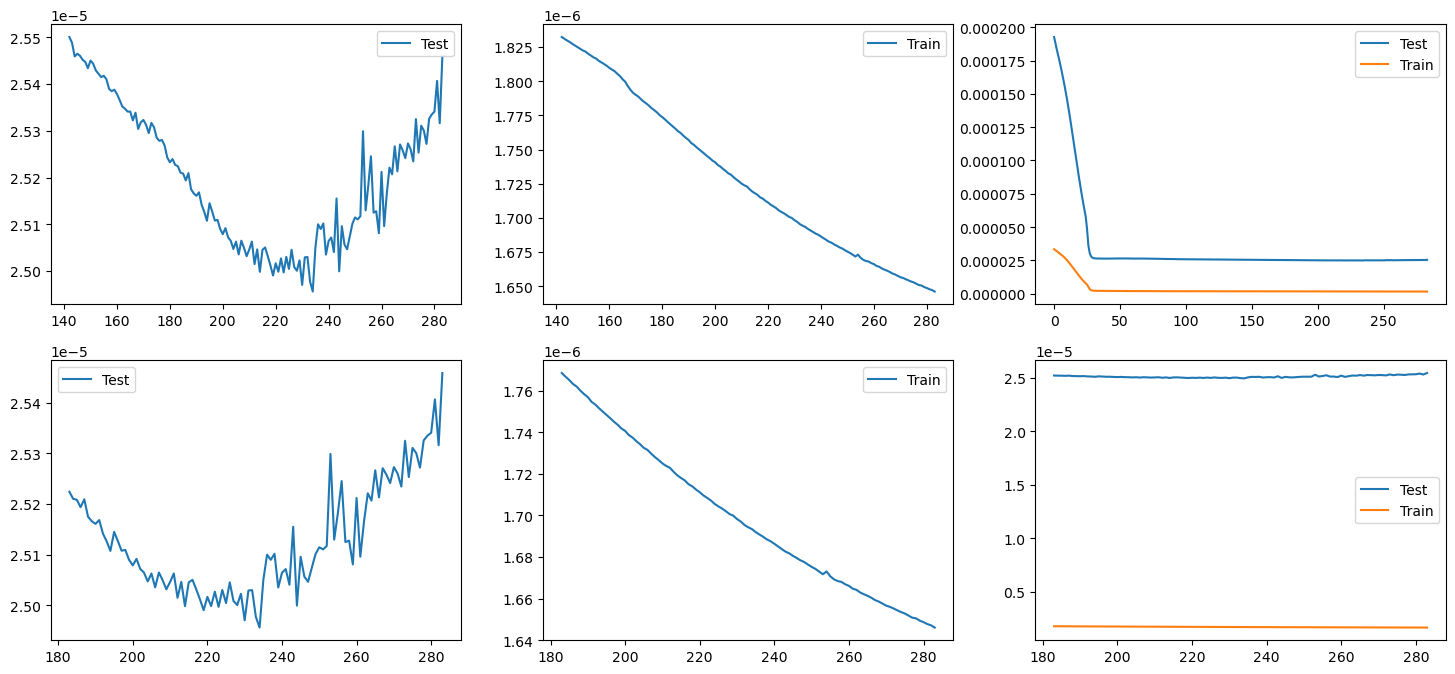

In [14]:
cutStartPct = 0.5
zoomEndEpochs = 2 * early_stopper.patience
plot_helpers.plot_losses(
    [test_loss, train_loss], ["Test", "Train"], cutStartPct, zoomEndEpochs
)

In [15]:
x_test, y_test = test_dataset.tensors
# x_test=x_test.to(device)
y_test = y_test.squeeze().detach().cpu().numpy()
y_pred = model(x_test).squeeze().detach().cpu().numpy()

In [16]:
y_text = r"$C_{14}$"
# r2=np.empty(nzt)
# r=np.empty(nzt)
# for k in range(nzt):
#     r2[k]=r2_score(y_test[:,k], y_pred[:,k])
#     r[k]=np.corrcoef(y_test[:,k], y_pred[:,k])[0, 1]
r2 = r2_score(y_test, y_pred)
r = np.corrcoef(y_test, y_pred)[0, 1]

print("Statistics for " + y_text)
print("R^2: %.4f" % np.mean(r2))
print("Correlation: %.4f" % +np.mean(r) + "\n")

Statistics for $C_{14}$
R^2: -0.3107
Correlation: 0.3446



Text(0.5, 1.0, '$C_{14}$')

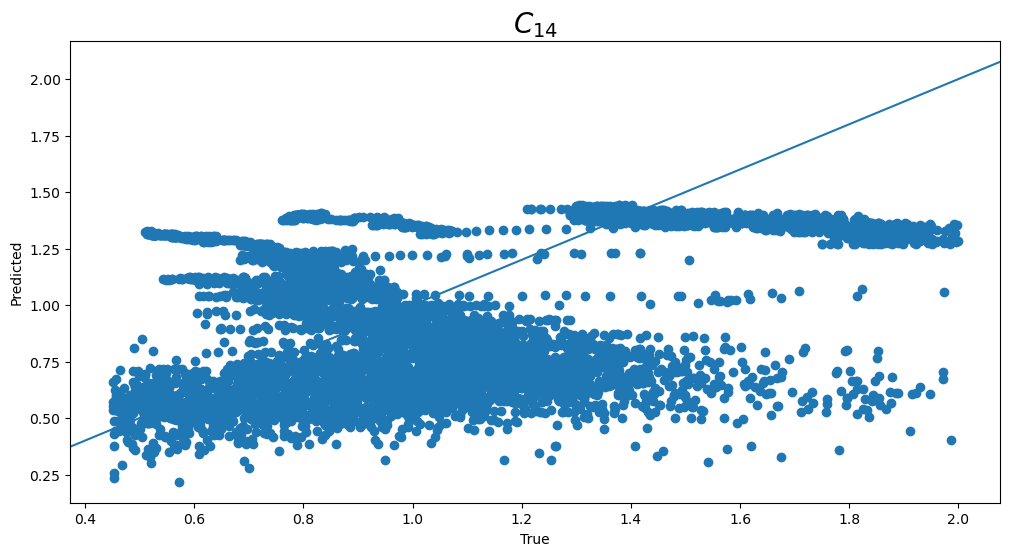

In [17]:
l1 = "Predicted"
l2 = "True"
nvar = 1
# z=zt[0,:]
y_text = r"$C_{14}$"

# fig1,ax1 = plt.subplots(1,nvar,figsize = (12, 6))
fig2, ax2 = plt.subplots(1, nvar, figsize=(12, 6))
# fig3,ax3 = plt.subplots(1,nvar,figsize = (12, 6))

ax2.scatter(y_test, y_pred)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin, xmax], [xmin, xmax])
ax2.set_xlim([xmin, xmax])
# ax2.set_xlim([0,1])
# ax2.set_ylim([0,1])
ax2.set_xlabel(l2)
ax2.set_ylabel(l1)
ax2.set_title(y_text, fontsize=20)

Statistics for $C_{14}$
R^2: 0.2012
Correlation: 0.4551



Text(0.5, 1.0, '$C_{14}$')

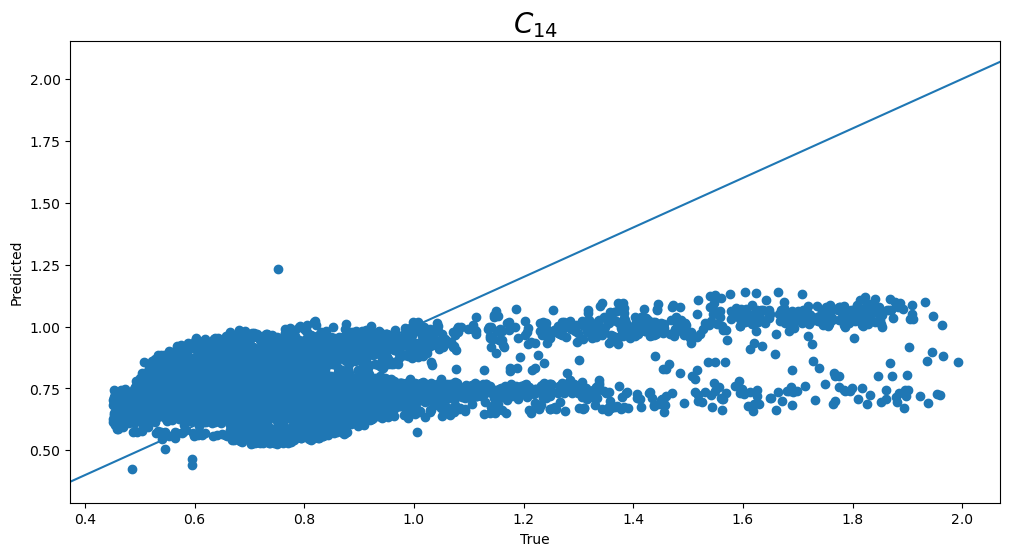

In [18]:
x_test, y_test = train_dataset.tensors
# x_test=x_test.to(device)
y_test = y_test.squeeze().detach().cpu().numpy()
y_pred = model(x_test).squeeze().detach().cpu().numpy()

y_text = r"$C_{14}$"
# r2=np.empty(nzt)
# r=np.empty(nzt)
# for k in range(nzt):
#     r2[k]=r2_score(y_test[:,k], y_pred[:,k])
#     r[k]=np.corrcoef(y_test[:,k], y_pred[:,k])[0, 1]
r2 = r2_score(y_test, y_pred)
r = np.corrcoef(y_test, y_pred)[0, 1]

print("Statistics for " + y_text)
print("R^2: %.4f" % np.mean(r2))
print("Correlation: %.4f" % +np.mean(r) + "\n")

fig2, ax2 = plt.subplots(1, nvar, figsize=(12, 6))
# fig3,ax3 = plt.subplots(1,nvar,figsize = (12, 6))

ax2.scatter(y_test, y_pred)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin, xmax], [xmin, xmax])
ax2.set_xlim([xmin, xmax])
# ax2.set_xlim([0,1])
# ax2.set_ylim([0,1])
ax2.set_xlabel(l2)
ax2.set_ylabel(l1)
ax2.set_title(y_text, fontsize=20)

In [19]:
# ax1.plot(r2,z,'b',linewidth=2)
# ax1.set_title(y_text,fontsize=20)
# ax1.set_xlabel(r'R$^2$',fontsize=20)
# ax1.set_ylabel(r'$\frac{z}{z_{\text{top}}}$',rotation=0,fontsize=20)
# print("Avg. across all levels for "+y_text)
# print("R^2: %.4f" % np.mean(r2) )
# print("Correlation: %.4f" % +np.mean(r)+"\n")

# for it in range(y_pred.shape[0]):
#     ax3.plot(y_pred[it],z,'r',label=l1)
#     ax3.plot(y_test[it],z,'k',label=l2)
#     l1,l2='__nolegend__','__nolegend__'
#     ax3.set_xlabel(y_text,fontsize=20)
#     ax3.set_ylabel(r'$z$',rotation=0,fontsize=20)

# # ax3.set_ylabel(r'$\frac{z}{z_{\text{top}}}$',rotation=0,fontsize=20)
# ax3[0].legend()
# l1='Predicted'
# l2='True'

In [20]:
# y_text=[r"$\overline{u'w'}/u_*^2$",r"$\overline{v'w'}/u_*^2$"]
# y_text=["U2DFSN","V2DFSN"]
# y_text[r'C_{14}']
# fig1,fig2,fig3=quickPlots(model,test_dataset,y_text,device)

In [21]:
# model.to("cpu")
# figure_fields=wandb.Image(plot_helpers.plot_fields(pyqg_dataset,model))
# wandb.log({"Fields": figure_fields})

In [22]:
# r2_upper,r2_lower,figure_power=metrics.get_offline_metrics(model,valid_loader)
# figure_power=wandb.Image(figure_power)
# wandb.log({"Power spectrum": figure_power})

In [23]:
# wandb.run.summary["r2_upper"]=r2_upper
# wandb.run.summary["r2_lower"]=r2_lower
# wandb.finish()